In [11]:
import pandas as pd
import geopandas as gpd
import entsoe
from urllib.error import HTTPError
import zipfile

In [12]:
def load_bidding_zones():
    
    gdfs: list[gpd.GeoDataFrame] = []
    
    for area in entsoe.Area:
        name = area.name
        try:
            url = f"https://raw.githubusercontent.com/EnergieID/entsoe-py/refs/heads/master/entsoe/geo/geojson/{name}.geojson"
            gdfs.append(gpd.read_file(url))
        except HTTPError:
            continue
    
    shapes = pd.concat(gdfs, ignore_index=True)  # type: ignore

    shapes.set_index("zoneName",inplace=True)
    
    return shapes

In [13]:
def align_with_ERAA_classification():
    
    unique_zones = pd.unique([i for i in bidding_zones.index if len(i) == 2])
    
    for zone in unique_zones:
        bidding_zones.loc[zone, "zone"] = zone + "00"
    
    bidding_zones.loc["DK_1", "zone"] = "DKW1"
    bidding_zones.loc["DK_2", "zone"] = "DKE1"
    bidding_zones.loc["IT_CALA", "zone"] = "ITCA"
    bidding_zones.loc["IT_CNOR", "zone"] = "ITCN"
    bidding_zones.loc["IT_CSUD", "zone"] = "ITCS"
    bidding_zones.loc["IT_NORD", "zone"] = "ITN1"
    bidding_zones.loc["IT_SARD", "zone"] = "ITSA"
    bidding_zones.loc["IT_SICI", "zone"] = "ITSI"
    bidding_zones.loc["IT_SUD", "zone"] = "ITS1"
    bidding_zones.loc["NO_4", "zone"] = "NON1"
    bidding_zones.loc["NO_3", "zone"] = "NOM1"
    bidding_zones.loc["NO_2", "zone"] = "NOS2"
    bidding_zones.loc["NO_5", "zone"] = "NOS3"
    bidding_zones.loc["NO_1", "zone"] = "NOS1"
    bidding_zones.loc["SE_1", "zone"] = "SE01"
    bidding_zones.loc["SE_2", "zone"] = "SE02"
    bidding_zones.loc["SE_3", "zone"] = "SE03"
    bidding_zones.loc["SE_4", "zone"] = "SE04"

In [14]:
def extract_shape_files():
    with zipfile.ZipFile("data/nuts24_regions.zip") as zip_f:
        zip_f.extract("NUTS_RG_01M_2024_3035_LEVL_0.geojson","data/nuts_regions/")
    
    with zipfile.ZipFile("data/nuts13_regions.zip") as zip_f:
        zip_f.extract("NUTS_RG_01M_2013_3035_LEVL_1.geojson","data/nuts_regions/")

    with zipfile.ZipFile("data/moldova_regions.zip") as zip_f:
        zip_f.extract("mda_admbnda_unhcr_20220510_SHP/mda_admbnda_adm0_unhcr_20220510.shp","data/nuts_regions/")

    with zipfile.ZipFile("data/moldova_regions.zip") as zip_f:
        zip_f.extract("mda_admbnda_unhcr_20220510_SHP/mda_admbnda_adm0_unhcr_20220510.shp","data/nuts_regions/")
        zip_f.extract("mda_admbnda_unhcr_20220510_SHP/mda_admbnda_adm0_unhcr_20220510.sbn","data/nuts_regions/")
        zip_f.extract("mda_admbnda_unhcr_20220510_SHP/mda_admbnda_adm0_unhcr_20220510.sbx","data/nuts_regions/")
        zip_f.extract("mda_admbnda_unhcr_20220510_SHP/mda_admbnda_adm0_unhcr_20220510.prj","data/nuts_regions/")
        zip_f.extract("mda_admbnda_unhcr_20220510_SHP/mda_admbnda_adm0_unhcr_20220510.dbf","data/nuts_regions/")
        zip_f.extract("mda_admbnda_unhcr_20220510_SHP/mda_admbnda_adm0_unhcr_20220510.cpg","data/nuts_regions/")
        zip_f.extract("mda_admbnda_unhcr_20220510_SHP/mda_admbnda_adm0_unhcr_20220510.shx","data/nuts_regions/")

In [42]:
def add_missing_zones():
    
    moldova = gpd.read_file("data/nuts_regions/mda_admbnda_unhcr_20220510_SHP/mda_admbnda_adm0_unhcr_20220510.shp")
    
    nuts0 = gpd.read_file("data/nuts_regions/NUTS_RG_01M_2024_3035_LEVL_0.geojson")
    nuts0 = nuts0.to_crs("EPSG:4326")
    nuts0.set_index("NUTS_ID", inplace=True)
    
    nuts1 = gpd.read_file("data/nuts_regions/NUTS_RG_01M_2013_3035_LEVL_1.geojson")
    nuts1 = nuts1.to_crs("EPSG:4326")
    nuts1.set_index("NUTS_ID", inplace=True)
    
    bidding_zones.drop("DE_LU", inplace=True)
    bidding_zones.set_index("zone", inplace=True)
    
    bidding_zones.loc["DE00", "geometry"] = nuts0.loc["DE", "geometry"]
    bidding_zones.loc["LUG1", "geometry"] = nuts0.loc["LU", "geometry"]
    bidding_zones.loc["IE00", "geometry"] = nuts0.loc["IE", "geometry"]
    bidding_zones.loc["CY00", "geometry"] = nuts0.loc["CY", "geometry"]
    bidding_zones.loc["MT00", "geometry"] = nuts0.loc["MT", "geometry"]
    bidding_zones.loc["BA00", "geometry"] = nuts0.loc["BA", "geometry"]
    bidding_zones.loc["RS00", "geometry"] = nuts0.loc["RS", "geometry"]
    bidding_zones.loc["MK00", "geometry"] = nuts0.loc["MK", "geometry"]
    bidding_zones.loc["ME00", "geometry"] = nuts0.loc["ME", "geometry"]
    bidding_zones.loc["AL00", "geometry"] = nuts0.loc["AL", "geometry"]
    bidding_zones.loc["XK00", "geometry"] = nuts0.loc["XK", "geometry"]
    #bidding_zones.loc["TR00", "geometry"] = nuts0.loc["TR", "geometry"]
    bidding_zones.loc["UA00", "geometry"] = nuts0.loc["UA", "geometry"]
    bidding_zones.loc["UK00", "geometry"] = nuts1.query("CNTR_CODE == 'UK'").drop("UKN").unary_union
    bidding_zones.loc["UKNI", "geometry"] = nuts1.loc["UKN"].geometry
    bidding_zones.loc["UK00", "geometry"] = nuts1.filter(like="UK", axis=0).drop("UKN").unary_union
    bidding_zones.loc["MD00", "geometry"] = moldova.loc[0, "geometry"]

In [43]:
bidding_zones = load_bidding_zones()

In [44]:
align_with_ERAA_classification()

In [45]:
extract_shape_files()

In [46]:
add_missing_zones()

<AxesSubplot:>

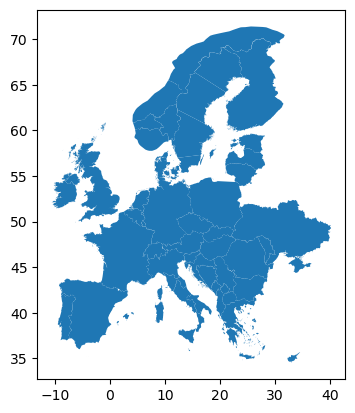

In [47]:
bidding_zones.plot()

In [33]:
pd.unique([i[:2] for i in bidding_zones.index])

array(['AT', 'BE', 'BG', 'HR', 'CZ', 'DK', 'EE', 'FI', 'FR', 'GR', 'HU',
       'IT', 'LV', 'LT', 'NL', 'NO', 'PL', 'PT', 'RO', 'SE', 'RS', 'SK',
       'SI', 'ES', 'CH', 'DE', 'LU', 'IE', 'CY', 'MT', 'UA', 'UK', 'MD'],
      dtype=object)

In [36]:
bidding_zones.to_file("resources/bidding_zones.geojson")